In [1]:
from collections import defaultdict
import itertools
import json
import sys
import os
import random

from datasets import load_dataset
from IPython.display import HTML
from matplotlib import pyplot as plt

_PATH = '/Users/sireeshgururaja/src/11-797-multidoc2dial/multidoc2dial/'
sys.path.append(os.path.join(_PATH))  # noqa: E402 # isort:skip

In [2]:
val_data = json.load(open(_PATH + 'data/multidoc2dial/multidoc2dial_dial_validation.json','r'))
docs = json.load(open(_PATH + 'data/multidoc2dial/multidoc2dial_doc.json','r'))

# dialogue act type. Are these all `query_condition?`
DAs      = [line.strip() for line in open(_PATH + 'data/mdd_all/dd-generation-structure/val.{}'.format('da'), "r").readlines()]
# domain - dmv, ssa, studentaid, va
domains  = [line.strip() for line in open(_PATH + 'data/mdd_all/dd-generation-structure/val.{}'.format('domain'), "r").readlines()]
# gold passage ID to answer this question
pids     = [line.strip() for line in open(_PATH + 'data/mdd_all/dd-generation-structure/val.{}'.format('pids'), "r").readlines()]
# query IDs, in the format {ID}_{turn}
qids     = [line.strip() for line in open(_PATH + 'data/mdd_all/dd-generation-structure/val.{}'.format('qids'), "r").readlines()]
# the actual text of the query
sources  = [line.strip() for line in open(_PATH + 'data/mdd_all/dd-generation-structure/val.{}'.format('source'), "r").readlines()]
# Gold responses
targets  = [line.strip() for line in open(_PATH + 'data/mdd_all/dd-generation-structure/val.{}'.format('target'), "r").readlines()]
# Gold article titles
titles   = [line.strip() for line in open(_PATH + 'data/mdd_all/dd-generation-structure/val.{}'.format('titles'), "r").readlines()]

In [3]:
# making sure we have the same number of document turns here.
len(DAs), len(domains), len(pids), len(qids), len(sources), len(targets), len(titles)

(4201, 4201, 4201, 4201, 4201, 4201, 4201)

In [4]:
retr_results = [line.replace('####', '\t').replace('\n', '').split('\t') for line in open('Results_retrieval.txt', "r").readlines()]
grounding_pids = []
grounding_titles = []
for x in retr_results:
    len_ = len(x)
    grounding_titles.append(x[:len_//2])
    grounding_pids.append(x[len_//2:])


hypos = [line.strip() for line in open('Results_generation.txt', "r").readlines()]
assert len(DAs) == len(domains) == len(pids) == len(qids) == len(sources) == len(targets) == len(titles) == len(retr_results) == len(hypos)

In [5]:
len(hypos)

4201

In [12]:
from scripts.rag.utils_rag import exact_match_score, f1_score

def metric_max_over_ground_truths(metric_fn, prediction, ground_truths):
    return max(metric_fn(prediction, gt) for gt in ground_truths)

from datasets import load_metric
metric = load_metric("sacrebleu")

generation_metrics = []
metrics_by_query = defaultdict(lambda: [])
metrics_by_turn_no = defaultdict(lambda: [])

for qid, prediction, ground_truths in zip(qids, hypos, targets):
    query_group, turn_id = qid.split("_")
    em_i = metric_max_over_ground_truths(exact_match_score, prediction, [ground_truths]) 
    f1_i = metric_max_over_ground_truths(f1_score, prediction, [ground_truths])
    metric.add_batch(predictions=[prediction], references=[[ground_truths]])
    sbleu_i = metric.compute()["score"]
    metrics_dict = {'EM' : em_i, 'F1' : f1_i, 'sacrebleu' : sbleu_i}
    generation_metrics.append(metrics_dict)
    metrics_by_query[query_group].append(metrics_dict)
    metrics_by_turn_no[turn_id].append(metrics_dict)


In [7]:
def text2line(text):
    return text.replace("\n", " ").replace("\r", " ").replace("\t", " ").strip()

def split_text_section(spans, title):
    def get_text(buff, title, span):
        text = " ".join(buff).replace("\n", " ")
        parent_titles = [title.replace("/", "-").rsplit("#")[0]]
        if len(span["parent_titles"]) > 1:
            parent_titles = [ele['text'].replace("/", "-").rsplit("#")[0] for ele in span["parent_titles"]]
        text = " / ".join(parent_titles) + " // " + text
        return text2line(text)

    buff = []
    pre_sec, pre_title, pre_span = None, None, None
    passages = []
    subtitles = []
        
    for span_id in spans:
        span = spans[span_id]
        parent_titles = title
        if len(span["parent_titles"]) > 1:                        
            parent_titles = [ele['text'].replace("/", "-").rsplit("#")[0] for ele in span["parent_titles"]]
            parent_titles = " / ".join(parent_titles)
        if pre_sec == span["id_sec"] or pre_title == span["title"].strip():
            buff.append(span["text_sp"])
        elif buff:
            text = get_text(buff, title, pre_span)
            passages.append(text)
            subtitles.append(parent_titles)
            buff = [span["text_sp"]]
        else:
            buff.append(span["text_sp"])
        pre_sec = span["id_sec"]
        pre_span = span
        pre_title = span["title"].strip()
    if buff:
        text = get_text(buff, title, span)
        passages.append(text)
        subtitles.append(parent_titles)
    return passages, subtitles        

In [8]:
doc_passages = {}
all_passages = []
start_idx = 0
for domain in docs['doc_data']:
    for doc_idx, doc_id in enumerate(docs['doc_data'][domain].keys()):
        ex = docs['doc_data'][domain][doc_id]
        #passages = split_text(ex["doc_text"]) # Token-based segmentation
        passages, subtitles = split_text_section(ex["spans"], ex["title"])
        all_passages.extend(passages)
        doc_passages[ex["doc_id"]] = (start_idx, len(passages), doc_idx)
        start_idx += len(passages)
        
passage_map = {}
for title in doc_passages:
    psg_start_ix, n_psgs, doc_idx = doc_passages[title]
    for i in range(n_psgs):
        passage_map[psg_start_ix + i] = {"text": all_passages[psg_start_ix + i], "title": title, "doc_idx": doc_idx}

In [9]:
passage_map[1806]

{'text': 'Top 5 DMV Mistakes and How to Avoid Them //   3. Letting Insurance Lapse   Because we all pay indirectly for crashes involving uninsured motorists ,  New York State requires every motorist to maintain auto insurance every single day a vehicle is registered.  DMV works with insurance companies to electronically monitor your insurance coverage ,  and we know when coverage is dropped for any reason.  When that happens ,  we mail you an insurance inquiry letter to allow you to clear up the problem.  We send 500,000 inquiry letters a year.  If the inquiry letter does not resolve the problem ,  we must suspend the vehicle registration and ,  if it persists, your driver license!We suspend 300,000 registrations a year for failure to maintain insurance.  If you fail to maintain an updated address with us ,  you won t learn that you have an insurance problem ,  and we will suspend your registration and license.  Make sure you turn in your vehicle s license plates at DMV before you canc

In [13]:
dialogue_map = defaultdict(lambda:{})
doc_ids = []

for i, (qid, pid) in enumerate(zip(qids, pids)):
    dialogue_id, turn_id = qid.split("_")
    doc_idx = passage_map[int(pid)]["doc_idx"]
    dialogue_map[dialogue_id][int(turn_id)] = {
        "query": sources[i],
        "expected_response": targets[i],
        "predicted_response": hypos[i],
        "metrics": generation_metrics[i],
        "grounding_doc": doc_idx,
    } 
    doc_ids.append(doc_idx)

dialogue_map = dict(dialogue_map)

In [15]:
turn_template = """
<tr>
    <td style="width:70%">
        <b>🤨:</b> {query}</br></br>
        <b>📝:</b> {expected_response}</br></br>
        <b>🤖:</b> {predicted_response}</br></br> 
    </td>
    <td>
        <b>Turn Index:</b> {turn_idx}</br>
        F1: {F1} </br>
        sacrebleu: {sacrebleu} </br>
        EM: {EM} </br>
        <b>Grounding doc:</b> {grounding_doc}
    </td>
</tr>
"""

def render_turn_dict(turn_idx: int, turn_dict) -> str:
    return turn_template.format(turn_idx=turn_idx, **turn_dict, **turn_dict["metrics"])

def render_dialogue(dialogue_map, dialogue_id=None):
    if dialogue_id is None:
        dialogue_id = random.choice(list(dialogue_map.keys()))
    turn_renders = []
    for turn_idx, turn_dict in dialogue_map[dialogue_id].items():
        turn_renders.append(render_turn_dict(turn_idx, turn_dict))

    return HTML("""<style>td {text-align: left; } </style><table>""" + "\n".join(turn_renders) + "</table>", )

render_dialogue(dialogue_map)

"🤨: Hi there. I would like to know, what happens with an adult with a disability if this one wants to get access to the social security benefits.[SEP] 📝: Sure, no problem. Well. If you have all the requirements you can apply for the supplemental security income online. 🤖: You can now file for Supplemental Security Income SSI online but only if you meet certain requirements.",Turn Index: 1 F1: 0.5882352941176471 sacrebleu: 2.5460814687679805 EM: False Grounding doc: 62
"🤨: Great! That's really great! But if this person have worked long enough may also receive the social security benefits as well as ssi?[SEP]agent: Sure, no problem. Well. If you have all the requirements you can apply for the supplemental security income online. ||user: Hi there. I would like to know, what happens with an adult with a disability if this one wants to get access to the social security benefits. 📝: Yes, that's right. That way people without any disability also can have this benefits. 🤖: Yes, they can. If they have worked long enough, they can get Supplemental Security Income (SSI) as well.",Turn Index: 3 F1: 0.1875 sacrebleu: 4.141141330484801 EM: False Grounding doc: 62
"🤨: If I want to apply for Medicare, Is there an age requirement before I can apply?[SEP]agent: Yes, that's right. That way people without any disability also can have this benefits.||user: Great! That's really great! But if this person have worked long enough may also receive the social security benefits as well as ssi?||agent: Sure, no problem. Well. If you have all the requirements you can apply for the supplemental security income online. ||user: Hi there. I would like to know, what happens with an adult with a disability if this one wants to get access to the social security benefits. 📝: You should sign up for Medicare three months before reaching age 65 , even if you are not ready to start receiving retirement benefits 🤖: Yes, you must be 65 years old or older, to apply.",Turn Index: 5 F1: 0.1764705882352941 sacrebleu: 1.9660670751694698 EM: False Grounding doc: 79
"🤨: if i am not ready to retire can I apply?[SEP]agent: Unfortunately, no relevant information is found.||user: no||agent: did you want to enroll in Medicare part B?||agent: You should sign up for Medicare three months before reaching age 65 , even if you are not ready to start receiving retirement benefits||user: If I want to apply for Medicare, Is there an age requirement before I can apply?||agent: Yes, that's right. That way people without any disability also can have this benefits.||user: Great! That's really great! But if this person have worked long enough may also receive the social security benefits as well as ssi?||agent: Sure, no problem. Well. If you have all the requirements you can apply for the supplemental security income online. ||user: Hi there. I would like to know, what happens with an adult with a disability if this one wants to get access to the social security benefits. 📝: You can apply online for Medicare even if you are not ready to retire 🤖: Yes, you can. If you are not getting Social Security and you are not ready to retire, you can still apply.",Turn Index: 10 F1: 0.5714285714285714 sacrebleu: 19.940445989088907 EM: False Grounding doc: 79


In [21]:
nonshift_f1s = []
shift_f1s = []
init_f1s = []

nonshift_sb = []
shift_sb = []
init_sb = []

for dialogue_id, turns_dict in dialogue_map.items():
    prev_grounding_doc = None
    for turn, turn_dict in turns_dict.items():
        if prev_grounding_doc is None:
            init_f1s.append(turn_dict["metrics"]["F1"])
            init_sb.append(turn_dict["metrics"]["sacrebleu"])
        elif turn_dict["grounding_doc"] != prev_grounding_doc:
            shift_f1s.append(turn_dict["metrics"]["F1"])
            shift_sb.append(turn_dict["metrics"]["sacrebleu"])
        else:
            nonshift_f1s.append(turn_dict["metrics"]["F1"])
            nonshift_sb.append(turn_dict["metrics"]["sacrebleu"])
        prev_grounding_doc = turn_dict["grounding_doc"]




In [24]:
len(init_f1s), len(shift_f1s), len(nonshift_f1s)

(661, 905, 2635)

{'bodies': [<matplotlib.collections.PolyCollection at 0x2a8e7abb0>,
 'cmeans': <matplotlib.collections.LineCollection at 0x2a8ddad30>,
 'cmaxes': <matplotlib.collections.LineCollection at 0x2a8f38640>,
 'cmins': <matplotlib.collections.LineCollection at 0x2a8f38a60>,
 'cbars': <matplotlib.collections.LineCollection at 0x2a8f2b250>}

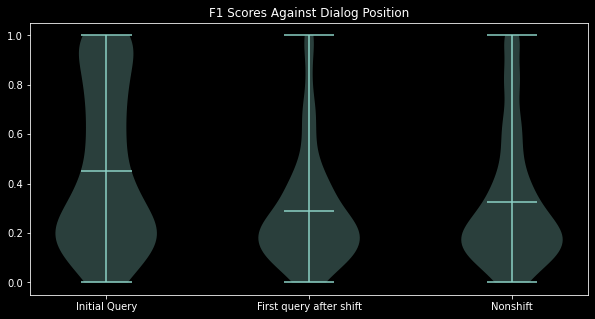

In [35]:
fig, ax = plt.subplots(figsize=(10,5))
ax.set_title("F1 Scores Against Dialog Position")
ax.set_xticks([1,2,3], labels=["Initial Query", "First query after shift", "Nonshift"])
ax.violinplot([init_f1s, shift_f1s, nonshift_f1s], showmeans=True)

{'bodies': [<matplotlib.collections.PolyCollection at 0x2a8f9d7c0>,
 'cmeans': <matplotlib.collections.LineCollection at 0x2a8f9d6d0>,
 'cmaxes': <matplotlib.collections.LineCollection at 0x2a8fa56a0>,
 'cmins': <matplotlib.collections.LineCollection at 0x2a8fa5ac0>,
 'cbars': <matplotlib.collections.LineCollection at 0x2a8f8dfd0>}

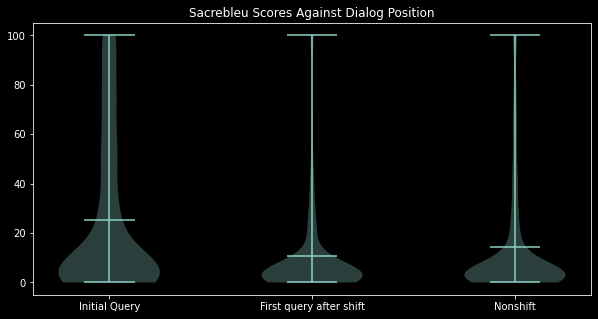

In [36]:
fig, ax = plt.subplots(figsize=(10,5))
ax.set_title("Sacrebleu Scores Against Dialog Position")
ax.set_xticks([1,2,3], labels=["Initial Query", "First query after shift", "Nonshift"])
ax.violinplot([init_sb, shift_sb, nonshift_sb], showmeans=True)